# Calcula de los DG

Equation

DG = Sum_i^n G(W_i) - nG(W)

n es el número de moléculas de agua, G(W) es la energía libre de Gibbs de la molécula de agua y G(W_i) es energía libre de Gibbs de la molécula de agua en la geometrias respectivas del agregados en cuestión.

In [10]:
from pathlib import Path
from glob import glob
from itertools import cycle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from natsort import index_natsorted
from brokenaxes import brokenaxes

from ase import Atoms, Atom
from pmutt.io import gaussian
from pmutt.statmech import StatMech, trans, vib, rot, elec
from pmutt.constants import kb, Na


# interactive plots
%matplotlib widget

In [11]:
KB_KCAL: float = kb("kcal/K")
AVOGADRO: float = Na

KB_KCAL_MOL: float = KB_KCAL * AVOGADRO
KB_KCAL_MOL


0.001985875020917578

## Path father of the inputs

In [12]:
working_directory = Path.cwd() / "../structures"

if not working_directory.exists():
    raise ValueError("The working directory does not exist.")


## Inputs files
* ADF.2013 outputs
* .txt with 2 columns: 1) name of the file of the output adf and 2) ADF energies in Ev
* G16 outputs

In [13]:
list_file_adf = str(working_directory) + "/monomers/"
list_file_g16 = glob(str(working_directory) + "/g16/sddall/*.log")
energies_file_adf = working_directory / ("monomers/energies.txt")

if not energies_file_adf.exists():
    raise ValueError("The energies file does not exist.")

if not list_file_adf:
    raise ValueError("The list of ADF files does not exist.")

if not list_file_g16:
    raise ValueError("The list of G16 files does not exist.")


## Reading coordinates and frequencies from ADF.2013

Se crea un dict de dict, por cada agregado

{"wxsy":{"w1":energy, "w2":energy, ...}, "wasb":{...}, ...}

In [14]:
with open(energies_file_adf, "r") as f_e_adf:
    for count, iline in enumerate(f_e_adf):
        pass
number_energies = count

In [15]:
clusters_waters_energies = {}
count = 0
with open(energies_file_adf, "r") as f_e_adf:
    while count <= number_energies:
        waters_energies = {}
        line = f_e_adf.readline().split()
        waters_energies[line[2]] = float(line[3])
        count += 1
        for i in range(int(line[0].replace("w",""))-1):
            line = f_e_adf.readline().split()
            waters_energies[line[2]] = float(line[3])
            count += 1
        clusters_waters_energies[str(line[0]+line[1])] = waters_energies

In [16]:
list_file_adf_output = []
with open(energies_file_adf, "r") as f_e_adf:
    for line in f_e_adf:
        list_file_adf_output.append(glob(list_file_adf + line.split()[0] + "/" + line.split()[1] + "/*out"))

In [17]:
find_lines_adf = {}
for name, files_adf in zip(clusters_waters_energies,list_file_adf_output):
    lines_water = {}
    for file_adf in files_adf:
        read_file_adf = Path(file_adf).read_text()

        """ Lines to read the geometry and frequencies form ADF.2013 output """
        start_line_geom = None
        last_line_geom = None
        start_line_freq = None
        last_line_freq = None
        for count, line in enumerate(read_file_adf.split("\n")):
            if (line == " Coordinates (Cartesian)"):
                start_line_geom = count + 6
            elif (
                line
                == " Coordinates (Cartesian, in Input Orientation)"
            ):
                start_line_geom = count + 6
            elif line == " Atomic Masses:":
                last_line_geom = count - 3
            elif line == " List of All Frequencies:":
                start_line_freq = count + 9
            elif line == " Statistical Thermal Analysis  ***  ideal gas assumed  ***":
                last_line_freq = count - 4
            elif start_line_geom and last_line_geom and start_line_freq and last_line_freq:
                break

        if not start_line_geom and not last_line_geom and not start_line_freq and not last_line_freq:
            raise ValueError(f"Geometries or frequencies in {file_adf} of ADF.2013 are not.")

        lines_water[Path(file_adf).stem] = [
            start_line_geom,
            last_line_geom,
            start_line_freq,
            last_line_freq,
        ]
    find_lines_adf[name] = lines_water

if not find_lines_adf:
    raise ValueError("Geometries and frequencies in ADF.2013 does not exist.")


In [18]:
clusters_geoms = {}
clusters_freqs = {}
for name, files_adf in zip(clusters_waters_energies,list_file_adf_output):
    waters_geoms_systems = {}
    waters_freqs_systems = {}
    for file_adf in files_adf:
        with open(Path(file_adf), "r") as f_adf:
            file_content = f_adf.readlines()

            """Atoms object with ase.Atoms"""
            last_line_geom = find_lines_adf[name][Path(file_adf).stem][1]
            start_line_geom = find_lines_adf[name][Path(file_adf).stem][0]
            lines_geom = last_line_geom - start_line_geom
            coord_system = []
            for i in range(lines_geom):
                line = file_content[start_line_geom + i].split()
                coord_system.append(Atom(line[1], (line[5], line[6], line[7])))
            waters_geoms_systems[Path(file_adf).stem] = Atoms(coord_system)
            """Frequencies"""
            last_line_freq = find_lines_adf[name][Path(file_adf).stem][3]
            start_line_freq = find_lines_adf[name][Path(file_adf).stem][2]
            lines_freq = last_line_freq - start_line_freq
            freq_system = []
            for i in range(lines_freq):
                line = file_content[start_line_freq + i].split()
                if float(line[0]) > 20.0:
                    freq_system.append(float(line[0]))
            waters_freqs_systems[Path(file_adf).stem] = freq_system

    clusters_geoms[name] = waters_geoms_systems
    clusters_freqs[name] = waters_freqs_systems


if not clusters_geoms:
    raise ValueError("The geometries of the systems does not exist.")
if not clusters_freqs:
    raise ValueError("The frequencies of the systems does not exist.")

clusters_geoms["w1s1"]["w1"].__dict__


{'_cellobj': Cell([0.0, 0.0, 0.0]),
 '_pbc': array([False, False, False]),
 'arrays': {'numbers': array([8, 1, 1]),
  'positions': array([[ 1.821376, -0.090165,  0.      ],
         [ 2.325945,  0.18731 ,  0.79892 ],
         [ 2.325945,  0.17731 , -0.79892 ]])},
 '_celldisp': array([[0.],
        [0.],
        [0.]]),
 '_constraints': [],
 'info': {},
 '_calc': None}

## Reading coordinates and frequencies from G16

In [117]:
find_lines_g16 = {}
for file_g16 in list_file_g16:
    read_file_g16 = Path(file_g16).read_text()

    """ Lines to read the geometry form G16 output """
    start_line_geom_g16 = None
    last_line_geom_g16 = None
    for count, line in enumerate(read_file_g16.split("\n")):

        if (
            line
            == "                          Input orientation:                          "
        ):
            start_line_geom_g16 = count + 5
        elif line == "                    Distance matrix (angstroms):":
            last_line_geom_g16 = count - 1
        elif start_line_geom_g16 and last_line_geom_g16:
            break
    find_lines_g16[Path(file_g16).stem] = [start_line_geom_g16, last_line_geom_g16]

if not find_lines_g16:
    raise ValueError("Geometries in G16 does not exist.")


In [118]:
geoms_systems_g16 = {}
freqs_systems_g16 = {}
energies_systems_g16 = {}
for file_g16 in list_file_g16:
    with open(Path(file_g16), "r") as f_g16:
        file_content = f_g16.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom_g16 = find_lines_g16[Path(file_g16).stem][1]
        start_line_geom_g16 = find_lines_g16[Path(file_g16).stem][0]
        lines_geom_g16 = last_line_geom_g16 - start_line_geom_g16
        coord_system_g16 = []
        for i in range(lines_geom_g16):
            line = file_content[start_line_geom_g16 + i].split()
            coord_system_g16.append(Atom(int(line[1]), (line[3], line[4], line[5])))
        geoms_systems_g16[Path(file_g16).stem] = Atoms(coord_system_g16)

    """Frequencies from G16"""
    freqs_systems_g16[Path(file_g16).stem] = gaussian.read_frequencies(
        file_g16, units="1/cm"
    )
    """Energies from G16 in Ev"""
    energies_systems_g16[Path(file_g16).stem] = gaussian.read_electronic_and_zpe(
        file_g16, units="eV/molecule"
    )

if not geoms_systems_g16:
    raise ValueError("The geometries of the systems does not exist.")
if not freqs_systems_g16:
    raise ValueError("The frequencies of the systems does not exist.")
if not energies_systems_g16:
    raise ValueError("The energies of the systems does not exist.")

geoms_systems_g16["w1s1"].__dict__


{'_cellobj': Cell([0.0, 0.0, 0.0]),
 '_pbc': array([False, False, False]),
 'arrays': {'numbers': array([80,  8,  1,  1]),
  'positions': array([[-0.22513 ,  0.010739,  0.      ],
         [ 1.821376, -0.090165,  0.      ],
         [ 2.325945,  0.18731 ,  0.79892 ],
         [ 2.325945,  0.17731 , -0.79892 ]])},
 '_celldisp': array([[0.],
        [0.],
        [0.]]),
 '_constraints': [],
 'info': {},
 '_calc': None}

In [ ]:
print(f"w1s1 Freqs:", freqs_systems_g16["w1s1"])
print(f"and Energy", energies_systems_g16["w1s1"])

In [ ]:
"""Translational"""
translation_w1s1 = trans.FreeTrans(
    n_degrees=3, atoms=geoms_systems_g16["w1s1"]
)
"""Vibrational"""
vibration_w1s1 = vib.HarmonicVib(
    vib_wavenumbers=[540.6193, 672.7271, 783.8093, 1725.6588, 3563.1071, 3667.4565]
)  # cm^-1
vibration_w1s1_a = vib.HarmonicVib(
    vib_wavenumbers=[540.6193, 672.7271, 783.8093, 1725.6588, 3563.1071, 3667.4565]
)  # cm^-1
"""Rotational"""
rotation_w1s1 = rot.RigidRotor(
    symmetrynumber=1, atoms=geoms_systems_g16["w1s1"]
)  # simmetry point C1
"""Electronic"""
electronic_w1s1 = elec.GroundStateElec(
    potentialenergy=-4594.372441886165, spin=0
)  # Ev
electronic_w1s1_a = elec.GroundStateElec(
    potentialenergy=-4594.01387237307921511430, spin=0
)  # Ev
"""StatMech Initialization G16"""
statmech_w1s1 = StatMech(
    name="w1s1",
    trans_model=translation_w1s1,
    vib_model=vibration_w1s1,
    rot_model=rotation_w1s1,
    elec_model=electronic_w1s1,
)
"""Thermochemistry"""
H = statmech_w1s1.get_H(T=298.15, units="kcal/mol")
S = statmech_w1s1.get_S(T=298.15, units="kcal/mol/K")
G = statmech_w1s1.get_G(T=298.15, units="kcal/mol")
U = statmech_w1s1.get_U(T=298.15, units="kcal/mol")
print(f"U {U} S {S} H {H} G {G}")
"""StatMech Initialization G16 a"""
statmech_w1s1_a = StatMech(
    name="w1s1",
    trans_model=translation_w1s1,
    vib_model=vibration_w1s1_a,
    rot_model=rotation_w1s1,
    elec_model=electronic_w1s1_a,
)
"""Thermochemistry"""
H_a = statmech_w1s1_a.get_H(T=298.15, units="kcal/mol")
S_a = statmech_w1s1_a.get_S(T=298.15, units="kcal/mol/K")
G_a = statmech_w1s1_a.get_G(T=298.15, units="kcal/mol")
U_a = statmech_w1s1_a.get_U(T=298.15, units="kcal/mol")
print(f"U_a {U_a} S_a {S_a} H_a {H_a} G_a {G_a}")


## Build object to statical mechanical calculation

In [19]:
clusters_translation = {}
clusters_vibration = {}
clusters_rotation = {}
clusters_electronic = {}
translation_g16 = {}
vibration_g16 = {}
rotation_g16 = {}
electronic_g16 = {}
for cluster_name, waters_geoms in clusters_geoms.items():
    water_translation = {}
    water_vibration = {}
    water_rotation = {}
    water_electronic = {}
    for water_name, water_geom in waters_geoms.items():

        """Translational"""
        water_translation[water_name] = trans.FreeTrans(
            n_degrees=3, atoms=clusters_geoms[cluster_name][water_name]
        )
        # translation_g16[water_name] = trans.FreeTrans(
        #     n_degrees=3, atoms=geoms_systems_g16[water_name]
        # )

        """Vibrational"""
        water_vibration[water_name] = vib.HarmonicVib(
            vib_wavenumbers=clusters_freqs[cluster_name][water_name]
        )  # cm^-1
        # vibration_g16[water_name] = vib.HarmonicVib(
        #     vib_wavenumbers=freqs_systems_g16[water_name]
        # )  # cm^-1

        """Rotational"""
        water_rotation[water_name] = rot.RigidRotor(
            symmetrynumber=1, atoms=clusters_geoms[cluster_name][water_name]
        )  # simmetry point C1
        # rotation_g16[water_name] = rot.RigidRotor(
        #     symmetrynumber=1, atoms=geoms_systems_g16[water_name]
        # )  # simmetry point C1

        """Electronic"""
        water_electronic[water_name] = elec.GroundStateElec(
            potentialenergy=float(clusters_waters_energies[cluster_name][water_name]), spin=0
        )  # Ev
        # electronic_g16[water_name] = elec.GroundStateElec(
        #     potentialenergy=float(energies_systems_g16[water_name]), spin=0
        # )  # Ev
    clusters_translation[cluster_name] = water_translation
    clusters_vibration[cluster_name] = water_vibration
    clusters_rotation[cluster_name] = water_rotation
    clusters_electronic[cluster_name] = water_electronic

if not clusters_translation : # and not translation_g16:
    raise ValueError("The translational or _g16 part of the systems does not exist.")
if not clusters_vibration : #and not vibration_g16:
    raise ValueError("The vibrational or _g16 part of the systems does not exist.")
if not clusters_rotation : #and not rotation_g16:
    raise ValueError("The rotational or _g16 part of the systems does not exist.")
if not clusters_electronic : # and not electronic_g16:
    raise ValueError("The electronic or _g16 part of the systems does not exist.")


## Calculate the partition function

In [20]:
clusters_statmech = {}
statmech_g16 = {}


for cluster_name, waters_geoms in clusters_translation.items():
    water_statmech = {}
    for water_name, water_geom in waters_geoms.items():

        """StatMech Initialization ADF.2013"""
        water_statmech[water_name] = StatMech(
            name=cluster_name + " " + water_name,
            trans_model=clusters_translation[cluster_name][water_name],
            vib_model=clusters_vibration[cluster_name][water_name],
            rot_model=clusters_rotation[cluster_name][water_name],
            elec_model=clusters_electronic[cluster_name][water_name],
        )
    clusters_statmech[cluster_name] = water_statmech

    # """StatMech Initialization G16"""
    # statmech_g16[name_file] = StatMech(
    #     name=name_file,
    #     trans_model=translation_g16[name_file],
    #     vib_model=vibration_g16[name_file],
    #     rot_model=rotation_g16[name_file],
    #     elec_model=electronic_g16[name_file],
    # )

if not clusters_statmech:
    raise ValueError("The statmech does not exist.")


## Thermochemistry quantities

In [21]:
clusters_values = {"systems": [],
    "H[kcal/mol]": [],
    "S[kcal/mol/K]": [],
    "G[kcal/mol]": [],
    "U[kcal/mol]": []}
for cluster_name, waters_geoms in clusters_translation.items():
    for water_name, water_geom in waters_geoms.items():
        H_statmech = clusters_statmech[cluster_name][water_name].get_H(T=298.15, units="kcal/mol")
        S_statmech = clusters_statmech[cluster_name][water_name].get_S(T=298.15, units="kcal/mol/K")
        G_statmech = clusters_statmech[cluster_name][water_name].get_G(T=298.15, units="kcal/mol")
        U_statmech = clusters_statmech[cluster_name][water_name].get_U(T=298.15, units="kcal/mol")
        clusters_values["systems"].append(cluster_name + " " + water_name)
        clusters_values["U[kcal/mol]"].append(U_statmech)
        clusters_values["S[kcal/mol/K]"].append(S_statmech)
        clusters_values["H[kcal/mol]"].append(H_statmech)
        clusters_values["G[kcal/mol]"].append(G_statmech)


pd.DataFrame(clusters_values).sort_values(by="systems",ascending=True,
    key=lambda x: np.argsort(index_natsorted(clusters_values["systems"])),
    ).reset_index(drop=True)


,systems,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
0,w1s1 w1,-314.051063,0.046590,-327.941918,-314.643548
1,w2s1 w1,-314.029100,0.046610,-327.925771,-314.621585
2,w2s1 w2,-314.028471,0.046610,-327.925131,-314.620956
3,w3s1 w1,-314.275525,0.046610,-328.172196,-314.868010
4,w3s1 w2,-205.796540,0.046610,-219.693200,-206.389025
...,...,...,...,...,...
136,w6s20 w1,-314.264370,0.046549,-328.143007,-314.856855
137,w6s20 w2,-316.689377,0.046960,-330.690532,-317.281862
138,w6s20 w3,-308.435475,0.048770,-322.976356,-309.027960
139,w6s20 w4,-314.274166,0.046555,-328.154498,-314.866651


## Thermochemistry quantities: different temperatures in kelvin
* ADF.2013
* G16

In [22]:
initital_temperature = 1
final_temperature = 1000
step_temperature = 1


In [128]:

absolute_thermochemistry_per_temperature = {}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    thermo_data = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
        "U[kcal/mol]": [],
    }

    for cluster_name, waters_geoms in clusters_translation.items():
        for water_name, water_geom in waters_geoms.items():

            """ ADF.2013 """
            H_statmech = clusters_statmech[cluster_name][water_name].get_H(T=temperature, units="kcal/mol")
            S_statmech = clusters_statmech[cluster_name][water_name].get_S(T=temperature, units="kcal/mol/K")
            G_statmech = clusters_statmech[cluster_name][water_name].get_G(T=temperature, units="kcal/mol")
            U_statmech = clusters_statmech[cluster_name][water_name].get_U(T=temperature, units="kcal/mol")
            thermo_data["system"].append(cluster_name + " " + water_name)
            thermo_data["H[kcal/mol]"].append(H_statmech)
            thermo_data["S[kcal/mol/K]"].append(S_statmech)
            thermo_data["G[kcal/mol]"].append(G_statmech)
            thermo_data["U[kcal/mol]"].append(U_statmech)

        absolute_thermochemistry_per_temperature[temperature] = (
            pd.DataFrame(thermo_data)
            .sort_values(
                by="system",
                ascending=True,
                key=lambda x: np.argsort(index_natsorted(thermo_data["system"])),
            )
            .reset_index(drop=True)
        )



if not absolute_thermochemistry_per_temperature:
    raise ValueError(
        "The absolute thermochemistry or _g16 values of the systems does not exist."
    )


In [ ]:
absolute_thermochemistry_per_temperature[298].tail()


# Calculo de Delta

In [55]:
energy_water_molecule = -14.28782550 # Ev
frequencies_water_molecule = [1594.091101, 3703.199734, 3805.951169]#cm^-1
#geometry
water_geometry = [Atom(symbol="O",  position=(0.000000,    0.000000,   -0.167560)),
    Atom(symbol="H",  position=(0.000000,   -0.764129,   -0.763829)),
    Atom(symbol="H",  position=(0.000000,    0.764129,   -0.763829))]

"""Translational"""
w_translation = trans.FreeTrans(
    n_degrees=3, atoms=Atoms(water_geometry)
)
"""Vibrational"""
w_vibration = vib.HarmonicVib(
    vib_wavenumbers=frequencies_water_molecule
)  # cm^-1
"""Rotational"""
w_rotation = rot.RigidRotor(
    symmetrynumber=1, atoms=Atoms(water_geometry)
)  # simmetry point C1
"""Electronic"""
w_electronic = elec.GroundStateElec(
    potentialenergy=float(energy_water_molecule), spin=0
)  # Ev
water_statmech = StatMech(
            name="water molecule",
            trans_model=w_translation,
            vib_model=w_vibration,
            rot_model=w_rotation,
            elec_model=w_electronic,
        )

In [61]:
print("U[kcal/mol]: ", water_statmech.get_U(T=298.15, units="kcal/mol"))
print("U[kcal/mol]: ", water_statmech.get_G(T=298.15, units="kcal/mol"))

U[kcal/mol]:  -314.69181487165434
U[kcal/mol]:  -327.97677397285435


In [63]:
delta_thermochemistry_per_temperature = {}
total_delta_thermochemistry_per_temperature = {}
for temperature in range(initital_temperature, final_temperature, step_temperature):

    thermo_data = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
        "U[kcal/mol]": [],
    }

    w_H = water_statmech.get_H(T=temperature, units="kcal/mol")
    w_S = water_statmech.get_S(T=temperature, units="kcal/mol/K")
    w_G = water_statmech.get_G(T=temperature, units="kcal/mol")
    w_U = water_statmech.get_U(T=temperature, units="kcal/mol")
    for cluster_name, waters_geoms in clusters_translation.items():
        cluster_H = 0.0
        cluster_S = 0.0
        cluster_G = 0.0
        cluster_U = 0.0
        water_number = 0
        for water_name, water_geom in waters_geoms.items():
            """ ADF.2013 """
            cluster_H += clusters_statmech[cluster_name][water_name].get_H(T=temperature, units="kcal/mol")
            cluster_S += clusters_statmech[cluster_name][water_name].get_S(T=temperature, units="kcal/mol/K")
            cluster_G += clusters_statmech[cluster_name][water_name].get_G(T=temperature, units="kcal/mol")
            cluster_U += clusters_statmech[cluster_name][water_name].get_U(T=temperature, units="kcal/mol")
            water_number += 1

        thermo_data["system"].append(cluster_name)
        thermo_data["H[kcal/mol]"].append(cluster_H - water_number*w_H)
        thermo_data["S[kcal/mol/K]"].append(cluster_S - water_number*w_S)
        thermo_data["G[kcal/mol]"].append(cluster_G - water_number*w_G)
        thermo_data["U[kcal/mol]"].append(cluster_U - water_number*w_U)

        delta_thermochemistry_per_temperature[temperature] = (
            pd.DataFrame(thermo_data)
            .sort_values(
                by="system",
                ascending=True,
                key=lambda x: np.argsort(index_natsorted(thermo_data["system"])),
            )
            .reset_index(drop=True)
        )

if not delta_thermochemistry_per_temperature:
    raise ValueError(
        "The absolute thermochemistry or _g16 values of the systems does not exist."
    )

In [77]:
delta_thermochemistry_per_temperature[298]

,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol],U[kcal/mol]
0,w1s1,0.048267,0.000045,0.034862,0.048267
1,w2s1,0.141087,0.000129,0.102666,0.141087
2,w3s1,108.126594,0.000129,108.088172,108.126594
3,w3s2,-0.602469,-0.003254,0.367363,-0.602469
4,w3s3,239.419321,-0.003254,240.389153,239.419321
5,w4s1,28.665628,-0.003254,29.635460,28.665628
6,w4s2,108.372283,0.000133,108.332759,108.372283
7,w4s3,21.661832,0.000133,21.622308,21.661832
8,w4s4,-0.805622,0.000133,-0.845146,-0.805622
9,w5s1,135.405818,-0.002585,136.176224,135.405818


In [75]:
max_number_of_waters = 6

dict_relative_population_delta_G = {
    "system": delta_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_G = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        delta_G = delta_thermochemistry_per_temperature[temperature][
            delta_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["G[kcal/mol]"]

        total_delta_G = np.exp(-delta_G / KB_KCAL_MOL / temperature).sum()

        population_delta_G = (
            np.exp(-delta_G / KB_KCAL_MOL / temperature) / total_delta_G
        )

        list_of_delta_G.append(population_delta_G)

    dict_relative_population_delta_G[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_G).T for value in sublist
    ]


df_relative_population_delta_G = pd.DataFrame(dict_relative_population_delta_G)

/home/danian/hg2w/thermo/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/danian/hg2w/thermo/lib/python3.6/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Text(0, 0.5, 'Relative Population $\\Delta$G')

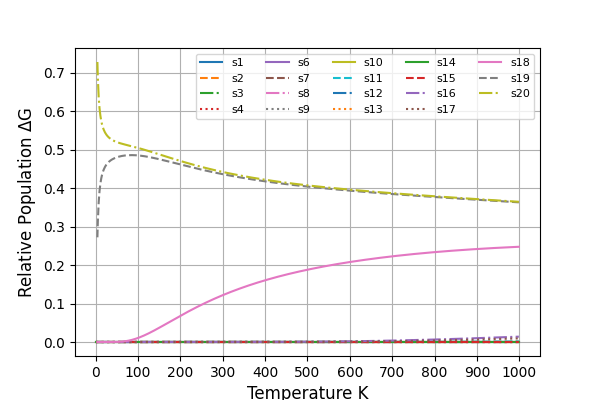

In [76]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)

## DH

In [ ]:
max_number_of_waters = 6

dict_relative_population_delta_H = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_H = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        H_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["H[kcal/mol]"]
        )

        H_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["H[kcal/mol]"]

        delta_H = H_values - H_reference

        total_delta_H = np.exp(-delta_H / KB_KCAL_MOL / temperature).sum()

        population_delta_H = (
            np.exp(-delta_H / KB_KCAL_MOL / temperature) / total_delta_H
        )

        list_of_delta_H.append(population_delta_H)

    dict_relative_population_delta_H[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_H).T for value in sublist
    ]


df_relative_population_delta_H = pd.DataFrame(dict_relative_population_delta_H)


## DG

In [ ]:
max_number_of_waters = 6

dict_relative_population_delta_G = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_G = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        G_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["G[kcal/mol]"]
        )

        G_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["G[kcal/mol]"]

        delta_G = G_values - G_reference

        total_delta_G = np.exp(-delta_G / KB_KCAL_MOL / temperature).sum()

        population_delta_G = (
            np.exp(-delta_G / KB_KCAL_MOL / temperature) / total_delta_G
        )

        list_of_delta_G.append(population_delta_G)

    dict_relative_population_delta_G[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_G).T for value in sublist
    ]


df_relative_population_delta_G = pd.DataFrame(dict_relative_population_delta_G)


In [ ]:
df_relative_population_delta_G[["system", "T=300"]].tail()


## DU

In [ ]:
max_number_of_waters = 6

dict_relative_population_delta_U = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_U = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        U_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["U[kcal/mol]"]
        )

        U_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["U[kcal/mol]"]

        delta_U = U_values - U_reference

        total_delta_U = np.exp(-delta_U / KB_KCAL_MOL / temperature).sum()

        population_delta_U = (
            np.exp(-delta_U / KB_KCAL_MOL / temperature) / total_delta_U
        )

        list_of_delta_U.append(population_delta_U)

    dict_relative_population_delta_U[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_U).T for value in sublist
    ]


df_relative_population_delta_U = pd.DataFrame(dict_relative_population_delta_U)


## DS

In [ ]:
max_number_of_waters = 6

dict_relative_population_delta_S = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_S = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        S_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["S[kcal/mol/K]"]
        )

        S_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["S[kcal/mol/K]"]

        delta_S = S_values - S_reference

        total_delta_S = np.exp(-delta_S / KB_KCAL_MOL / temperature).sum()

        population_delta_S = (
            np.exp(-delta_S / KB_KCAL_MOL / temperature) / total_delta_S
        )

        list_of_delta_S.append(population_delta_S)

    dict_relative_population_delta_S[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_S).T for value in sublist
    ]


df_relative_population_delta_S = pd.DataFrame(dict_relative_population_delta_S)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]




linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(10, 6))

grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0, 0])
ax1.grid()

ax2 = plt.subplot(grid[0, 1])
ax2.grid()

ax3 = plt.subplot(grid[1, 0])
ax3.grid()

ax4 = plt.subplot(grid[1, 1])
ax4.grid()

# ------------------------------------------------------------------------------
temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax1.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax1.xaxis.set_major_locator(MultipleLocator(100))

# ax1.legend(loc="upper right", fontsize=8, ncol=5)
# ax1.set_xlabel(r"Temperature K", fontsize=12)
ax1.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)
ax1.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax2.plot(
        temp,
        df_relative_population_delta_H[
            df_relative_population_delta_H["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax2.xaxis.set_major_locator(MultipleLocator(100))

# ax2.legend(loc="upper right", fontsize=8, ncol=5)
# ax2.set_xlabel(r"Temperature K", fontsize=12)
ax2.xaxis.set_tick_params(labelsize=8)
ax2.set_ylabel(r"Relative Population $\Delta$H", fontsize=12)
ax2.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax3.plot(
        temp,
        df_relative_population_delta_S[
            df_relative_population_delta_S["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax3.xaxis.set_major_locator(MultipleLocator(100))

# ax3.legend(loc="upper right", fontsize=8, ncol=5)
# ax3.set_xlabel(r"Temperature K", fontsize=12)
ax3.xaxis.set_tick_params(labelsize=8)
ax3.set_ylabel(r"Relative Population $\Delta$S", fontsize=12)
ax3.xaxis.set_tick_params(labelsize=8)

# ------------------------------------------------------------------------------

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax4.plot(
        temp,
        df_relative_population_delta_U[
            df_relative_population_delta_U["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax4.xaxis.set_major_locator(MultipleLocator(100))

# ax4.legend(loc="upper right", fontsize=8, ncol=5)
# ax4.set_xlabel(r"Temperature K", fontsize=12)
ax4.xaxis.set_tick_params(labelsize=8)
ax4.set_ylabel(r"Relative Population $\Delta$U", fontsize=12)
ax4.xaxis.set_tick_params(labelsize=8)

In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w5s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.legend(loc="upper right", fontsize=8, ncol=3)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w4s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))


ax.legend(loc="center left", fontsize=10, ncol=1)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.legend(loc="center left", fontsize=10, ncol=3)
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


In [ ]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111)
# ax.grid()

bax = brokenaxes( ylims=((-0.01, 0.07), (0.9, 1.01)), hspace=.2)
bax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    bax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


bax.legend(loc="center left", fontsize=10, ncol=3)
# bax.xaxis.set_major_locator(MultipleLocator(100))
bax.locator_params(nbins=10, axis='y')
bax.locator_params(nbins=20, axis='x')

bax.set_xlabel(r"Temperature K", fontsize=12)
bax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)
